# Vehicle Detection Project

In [2]:
#All necessary imports
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from HelperFunctions import *
from scipy.ndimage.measurements import label




# Reading Cars and Non-Car Images

8792
8968


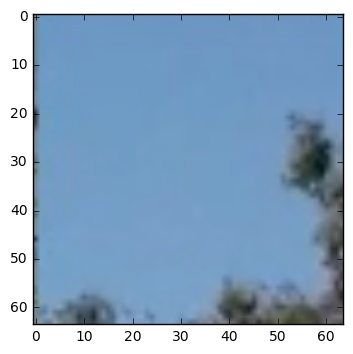

In [3]:
#Reading cars and non car data
cars = glob.glob('vehicles/vehicles/*/*.png')
notcars = glob.glob('non-vehicles/non-vehicles/*/*.png')
print(len(cars))
print(len(notcars))
car_image = mpimg.imread(cars[0])
notcar_image = mpimg.imread(notcars[0])
#plt.imshow(car_image)
plt.imshow(notcar_image)

#  Feature Extraction and Training the Classifier

In [4]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 24    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
xy_window = (64, 64)
xy_overlap = (0.75, 0.75)
x_start_stop = [600,1280]
y_start_stop = [400, 720] # Min and max in y to search in slide_window()

# The below is used to generate an example of a Hog Visaualization image of an car image
# Code has been commented out
'''
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 5
pix_per_cell = 8
cell_per_block = 5
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
'''

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()



Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188
3.75 Seconds to train SVC...
Test Accuracy of SVC =  0.9761


# Testing the Classifer on a Sample Image

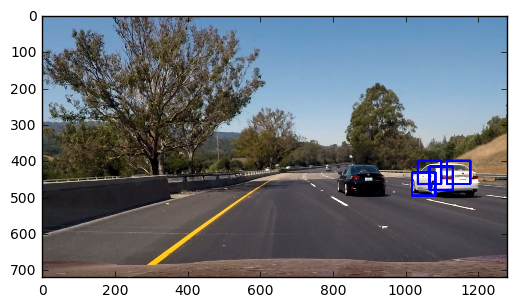

In [6]:
image = mpimg.imread('test_images/test6.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255


windows1 = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=xy_overlap)


windows2 = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=xy_overlap)

windows3 = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(128, 128), xy_overlap=xy_overlap)
windows = windows1 + windows2 + windows3

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       


window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

# Processing Video Stream by applying sliding window technique and Heat map

In [7]:
def add_heat(heatmap, bbox_list, last_N_frames=5):
    # Iterate through list of bboxes
    for box in bbox_list[-last_N_frames:]:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [8]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [9]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [10]:
def process_image(image):
    global bboxes_list
    
    #image = image.astype(np.float32)/255
    x_start_stop = [600,1280]
    
    '''
    windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=xy_window, xy_overlap=(0.5, 0.5))
    '''
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    
    for i in hot_windows:
        bboxes_list.append(i)
    
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
        
    # Add heat to each box in box list
    heat = add_heat(heat,bboxes_list,15)
    

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,0)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    #window_img = draw_boxes(np.copy(image), hot_windows, color=(0, 0, 255), thick=6)                    
  
    #Drawing the heatmap plot
    '''
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(window_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()
    '''
    
    return draw_img

In [11]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

bboxes_list = []


video = VideoFileClip("project_video.mp4")
project_clip = video.fl_image(process_image) #NOTE: this function expects color images!!
video_output = "output_tweak.mp4"
%time project_clip.write_videofile(video_output, audio=False)

#print("Bounding boxes List: ", bboxes_list)

'''
image = mpimg.imread('test_images/test1.jpg')
process_image(image)
'''

[MoviePy] >>>> Building video output_tweak.mp4
[MoviePy] Writing video output_tweak.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [53:02<00:02,  2.68s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_tweak.mp4 

Wall time: 53min 4s


"\nimage = mpimg.imread('test_images/test1.jpg')\nprocess_image(image)\n"